# kaggle_Predict_Future_Sales
**Predict 3 months of item sales at different stores**
https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data

for easy reading, below is the information from kaggle page

## Overview
### Description
This challenge serves as final project for the "How to win a data science competition" Coursera course.

In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

We are asking you to **predict total sales for every product and store in the next month**. By solving this competition you will be able to apply and enhance your data science skills.

### Evaluation

Submissions are evaluated by root mean squared error (RMSE). True target values are clipped into [0,20] range.

### Submission File

`For each id` in the `test set`, you must `predict a total number of sales`.
The file should contain a header and have the following format:<br>

ID,item_cnt_month<br>
0,0.5<br>
1,0.5<br>
2,0.5<br>
3,0.5<br>
etc.<br>

## Data Description
You are provided with daily historical sales data. The task is to forecast the **total amount of products sold in every shop for the test set**. `Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.`

### File descriptions
- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.
### Data fields
- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category 


## Loading and looking at the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from statsmodels.tsa.api import ExponentialSmoothing, Holt
import datetime
import warnings
warnings.simplefilter('ignore')

path='../input/demand-forecasting-kernels-only/' # to use when running in kaggle
path='./input/' # for local use # comment "#" this line if running in kaggle

for dirname, dirnames, filenames in os.walk(path):
    # print path to all subdirectories first.
    for subdirname in dirnames:
        print(os.path.join(dirname, subdirname))

    # print path to all filenames.
    for filename in filenames:
        print(os.path.join(dirname, filename))

./input/items.csv
./input/item_categories.csv
./input/sales_train_v2.csv
./input/sample_submission.csv
./input/shops.csv
./input/test.csv


In [2]:
start = datetime.datetime.now() # for timming purposes
# load the data and check contents
items = pd.read_csv(path + 'items.csv', index_col='item_id')
items.iloc[[0, -1]]

,item_name,item_category_id
item_id,,
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40
22169,Яйцо дракона (Игра престолов),69


- information from this file does not seems to be needed as the name and category are not used anywhere else and the items to be forecasted are in the test set

In [3]:
categories = pd.read_csv(path + 'item_categories.csv', index_col='item_category_id')
categories.iloc[[0, -1]]

,item_category_name
item_category_id,
0,PC - Гарнитуры/Наушники
83,Элементы питания


- information from this file does not seems to be needed either as the category is only referenced in the items file

In [4]:
shops = pd.read_csv(path + 'shops.csv', index_col='shop_id')
shops.iloc[[0, -1]]

,shop_name
shop_id,
0,"!Якутск Орджоникидзе, 56 фран"
59,"Ярославль ТЦ ""Альтаир"""


- information from this file does not seems to be needed as the stores to be included in the forecast will come from the test set
- deleting the unneeded DataFrames

In [5]:
del(items, categories, shops)

In [6]:
test = pd.read_csv(path + 'test.csv', index_col='ID')
test.iloc[[0, 5096, 5097, 5098, 5099, 5100, 5101, -1]]

,shop_id,item_id,.,..1,..2
ID,,,,,
0,5,5037,NaN,NaN,NaN
5096,5,16188,NaN,NaN,NaN
5097,5,15757,NaN,NaN,NaN
5098,5,19648,NaN,NaN,NaN
5099,5,969,NaN,NaN,NaN
5100,4,5037,NaN,NaN,NaN
5101,4,5320,NaN,NaN,NaN
214199,45,969,NaN,NaN,NaN


In [7]:
# The task is to forecast the total amount of products sold in every shop for the test set.
# identify unique shop_id and item_id in the test set
shop_unique = test.shop_id.unique()
item_unique = test.item_id.unique()
print('Unique shops in the test set: {}\r\nUnique items in the test set: {}'.format(
    len(shop_unique), len(item_unique)))
print('Expected entries in the submission file ({} * {}): {}'.format(
    len(shop_unique), len(item_unique), len(shop_unique) * len(item_unique)))
print('Number of records in test.csv: {}'.format(test.shape[0]))
print('Missing records (test.csv - expected): {}'.format(test.shape[0] - len(shop_unique) * len(item_unique)))


Unique shops in the test set: 42
Unique items in the test set: 5100
Expected entries in the submission file (42 * 5100): 214200
Number of records in test.csv: 214200
Missing records (test.csv - expected): 0


- The "Missing records (test.csv - expected): 0" indicates that all unique items and all unique shops are included in the test.csv file amd all of them need to be forecasted.   A number different from zero indicates that not all items or shops are included.
Note however that the order of the items in test.csv do not follow a sequential order, hence to generate the submission file we need to follow the order of the entries in file  by using pairs (shop_id[ID], item_id[ID]).

In [8]:
train = pd.read_csv(path + 'sales_train_v2.csv', dayfirst=True, parse_dates=['date'], index_col='date', )
train.iloc[[0, -1]]

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date,,,,,
2013-01-02,0,59,22154,999.0,1.0
2015-10-03,33,25,7460,299.0,1.0


In [9]:
train.drop(['date_block_num', 'item_price'], axis=1, inplace=True)
train.iloc[[0, -1]]

,shop_id,item_id,item_cnt_day
date,,,
2013-01-02,59,22154,1.0
2015-10-03,25,7460,1.0


- dropping the stores and items that are not part of the forecast to free up resources

In [10]:
x = train.shape[0]
x

2935849

In [11]:
train = train.query("shop_id in @shop_unique & item_id in @item_unique")
train.shape

(1224439, 3)

In [12]:
print('Percentage of records not used for the forecast: {0:.2%}'.format(train.shape[0] / x))

Percentage of records not used for the forecast: 41.71%


In [13]:
# view the dimensions of the data
train.pivot_table(index='shop_id', columns='item_id', values='item_cnt_day', 
                  aggfunc={'item_cnt_day':'count'}, margins=True, margins_name='Total', observed=True)

item_id,30,31,32,33,38,42,45,51,53,57,...,22118,22139,22145,22154,22162,22163,22164,22166,22167,Total
shop_id,,,,,,,,,,,,,,,,,,,,,
2,4.0,8.0,11.0,11.0,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,17.0,15472
3,19.0,9.0,15.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,1.0,NaN,4.0,NaN,6.0,NaN,5.0,14591
4,10.0,10.0,23.0,8.0,2.0,NaN,NaN,1.0,NaN,NaN,...,NaN,6.0,1.0,NaN,4.0,NaN,3.0,NaN,4.0,20070
5,17.0,10.0,27.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,4.0,NaN,12.0,2.0,10.0,NaN,4.0,21044
6,32.0,38.0,52.0,42.0,1.0,4.0,3.0,10.0,10.0,1.0,...,2.0,6.0,7.0,2.0,9.0,1.0,13.0,NaN,24.0,39518
7,21.0,12.0,51.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,10.0,4.0,1.0,4.0,NaN,4.0,NaN,5.0,30759
10,8.0,7.0,8.0,7.0,1.0,NaN,NaN,1.0,NaN,NaN,...,NaN,2.0,NaN,NaN,1.0,3.0,1.0,NaN,6.0,11159
12,3.0,12.0,1.0,15.0,2.0,NaN,1.0,NaN,1.0,1.0,...,3.0,5.0,NaN,NaN,2.0,NaN,5.0,NaN,120.0,19173
14,13.0,11.0,21.0,9.0,NaN,NaN,NaN,NaN,1.0,NaN,...,3.0,1.0,2.0,NaN,5.0,1.0,7.0,NaN,7.0,19597


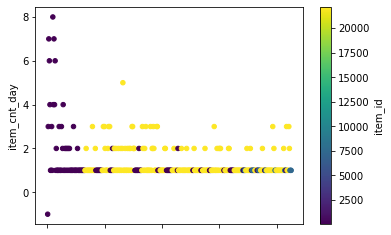

In [14]:
shopslist = [2, 55, 25]
itemslist = [30, 22166, 7460]
data = train.query("shop_id in @shopslist & item_id in @itemslist")
data['date2'] = data.reset_index().index + 1 
ax = data.plot.scatter(x='date2', y='item_cnt_day', c='item_id', colormap='viridis')


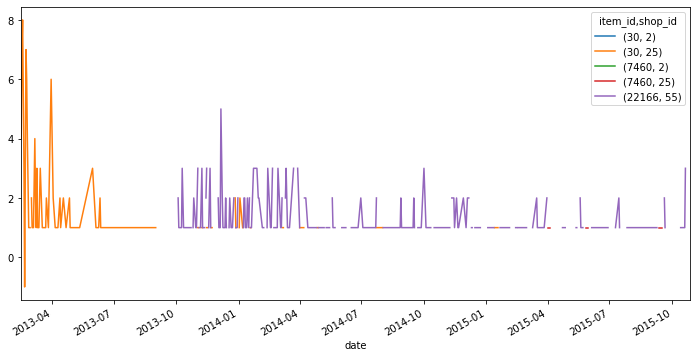

In [15]:
# sales history for some items/stores
shopslist = [2, 55, 25]
itemslist = [30, 22166, 7460]
data = train.query("shop_id in @shopslist & item_id in @itemslist")
data.reset_index().pivot_table(index=['date'], columns=['item_id', 'shop_id'], values='item_cnt_day', 
                  aggfunc={'item_cnt_day':'sum'}).plot(figsize=(12, 6));

In [16]:
# items with negative values in item_cnt_day
data = train.loc[train.loc[:, 'item_cnt_day'] < 0] 
x = data.pivot_table(index='shop_id', columns='item_id', values='item_cnt_day', 
                  aggfunc={'item_cnt_day':'sum'}, margins=True, margins_name='Total', observed=True)
x

item_id,30,31,32,33,38,57,109,269,313,325,...,22087,22091,22092,22102,22139,22145,22162,22164,22167,Total
shop_id,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-50.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-64.0
4,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-53.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-49.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-112.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.0,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,-53.0
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-200.0
14,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-85.0
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-62.0


In [17]:
# items with negative values in item_cnt_day
data.describe().astype('int')

,shop_id,item_id,item_cnt_day
count,2941,2941,2941
mean,31,8034,-1
std,17,5769,0
min,2,30,-16
25%,16,3676,-1
50%,31,5822,-1
75%,47,11930,-1
max,59,22167,-1


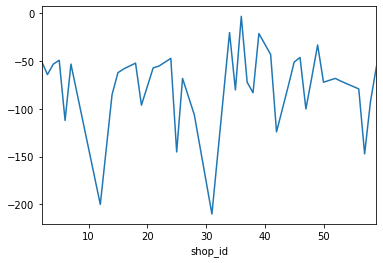

In [18]:
# view of the amount of "returns" or negative item_cnt_day per shop
x.loc[:, 'Total'][0:-1].plot();

In [19]:
# shops with more than xyz "returns" or negative item_cnt_day per shop 
xyz = -100
y = x.iloc[:-1, -1:]
y.loc[y.loc[:, 'Total'] < xyz, :].T

shop_id,6,12,25,28,31,42,57
item_id,,,,,,,
Total,-112.0,-200.0,-145.0,-106.0,-210.0,-124.0,-147.0


In [20]:
y.melt().describe().astype('int')

,value
count,40
mean,-75
std,42
min,-210
25%,-86
50%,-67
75%,-51
max,-3


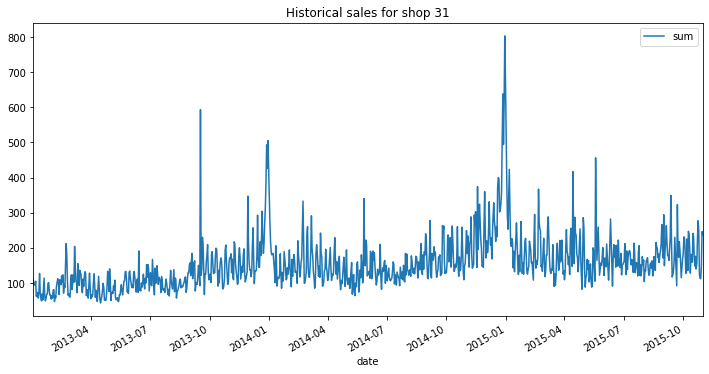

In [21]:
# plot for shops
shop = 31
data = train.groupby(['date', 'shop_id']).agg(sum=pd.NamedAgg(column='item_cnt_day', aggfunc='sum'))
data = data.reset_index().set_index('date')
data = data.query("shop_id == @shop").drop('shop_id', axis=1);
data.plot(title='Historical sales for shop {}'.format(shop), figsize=(12, 6));

In [22]:
# items with more than xyz "returns" or negative item_cnt_day per shop 
xyz = -20
z = x.iloc[-1:, :-1]
z.loc[:, z.loc['Total'] < xyz]

item_id,3732,3734,4051,4249,4870,5672,6497,6675,16787
shop_id,,,,,,,,,
Total,-33.0,-39.0,-21.0,-24.0,-21.0,-25.0,-21.0,-23.0,-23.0


In [23]:
z.melt().describe().astype('int')

,value
count,1216
mean,-2
std,3
min,-39
25%,-3
50%,-1
75%,-1
max,-1


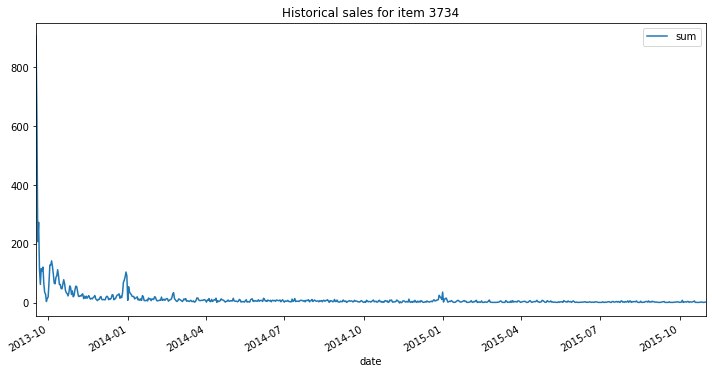

In [24]:
# plot for item 3734
item = 3734
data = train.groupby(['date', 'item_id']).agg(sum=pd.NamedAgg(column='item_cnt_day', aggfunc='sum'))
data = data.reset_index().set_index('date')
data = data.query("item_id == @item").drop('item_id', axis=1);
data.plot(title='Historical sales for item {}'.format(item), figsize=(12, 6));

In [25]:
data.tail()

,sum
date,
2015-10-26,2.0
2015-10-27,2.0
2015-10-28,1.0
2015-10-29,1.0
2015-10-31,2.0



## Initial toughts
- Item 22166 is only sold at shop 55, this is a heads up to be careful when selecting data for all **`NaN`** above as that item is nos sold in that shop and the query will return an empty DataFrame that willl generate problems for the forecast and the forecast for that should be zero (based on the currently available information).
- Some items were sold long ago but not during the past few months.
- shops 12 and 31 have the largest number of returns (200, 210)
- item 3734 has the largest number of returns (39) and the sales spike in 2013 bu went down significantly in the last two years
- Some items have negative value in the "item_cnt_day" which may means that returns were made or these are errors in the data set.   For this exercise negative numbers will be converted to zero as the numpy.polyfit weights requires positive values.   The negative ones will trigger an error "SVD did not converge in Linear Least Squares"


In [26]:
# replacing negative numbers with zero
train[train < 0] = 0
train.describe().astype('int')

,shop_id,item_id,item_cnt_day
count,1224439,1224439,1224439
mean,32,9614,1
std,16,6299,3
min,2,30,0
25%,19,4181,1
50%,31,7856,1
75%,46,15229,1
max,59,22167,2169


In [27]:
# Consolidating
train = train.groupby(['date', 'shop_id', 'item_id'])['item_cnt_day'].sum()
train = train.reset_index().set_index('date')

In [28]:
# Ientify shops/items with low/no sales (not enough points to forecast)
train.nsmallest(100, 'item_cnt_day').pivot_table(index='shop_id', columns='item_id', values='item_cnt_day',
    aggfunc='count').fillna('')

item_id,30,33,388,482,831,835,1829,2252,2308,2753,...,18059,19046,19119,19331,19337,19338,19597,19778,20212,21447
shop_id,,,,,,,,,,,,,,,,,,,,,
2,,,,,,,,,,,...,,,,,,,,,,
6,,,,,,,,,,,...,,,,,,,,,,
7,,,,,,,,,,,...,,,,,,,,,,
12,,,,1,1,,,,,1,...,1,,,,,,,,,
14,,,,,,,,,,,...,,,,,,,,,,
16,,,,,,,,,,,...,,,,,,,,,,
18,,,,,,,,,,,...,,,,,,,,,,
19,,,,,,,,,,,...,,,,,,,,,,
21,,,,,,,,,,,...,,,,,,,,,,


- The items/shops above and others do not have enough mumber of observations to forecast them based on historical sales.   A different approach needs to be made with these.   Like checking when was sales date; if too old then forecast mostlikely should be zero, or if relatively new, use the average sales or other ideas.


In [29]:
# Ientify largest 100 sales 
train.nlargest(100, 'item_cnt_day').pivot_table(index='shop_id', columns='item_id', values='item_cnt_day',
    aggfunc='sum').fillna('')


item_id,1971,2808,2964,3731,3732,3733,3734,4358,4392,6675,...,7807,10209,10210,11365,11369,11370,11373,16787,16790,20949
shop_id,,,,,,,,,,,,,,,,,,,,,
4,,,,,,,,,,,...,,,,,,,,,,104
5,,,,,,,,,,,...,,,,,,,,,,98
6,,,,138,148,,,,,,...,,110,89,,,,,,,
12,127,550,,624,106,142,109,,,,...,,480,187,103,412,932,3355,,97,2000
14,,,,117,,,,,,,...,,,,,,,,,,
15,,,,,,,,,,,...,,,,,,,,,,702
18,,,,145,156,,,,,,...,,,,,,,,,,
19,,,,98,,,,,,,...,,,,,,,,,,103
21,,,,,,,,,,,...,,,,,,,,,,101


- Some of these above may potentially be outliers above like item 20949 in shops 12 and 25 with 2000 and 1019 sales.

In [30]:
# check index (column 'ID') for consistency
mask = test.reset_index()['ID'].duplicated()
test.loc[mask]

,shop_id,item_id,.,..1,..2
ID,,,,,


- No duplicetd indices were found.

## Procedure for item x at shop y

- select the data associated with a shop/item based on the test.csv order
    - add missing dates adn fill them out with zero
- if there are not enough points to forecast:
    - reference_date: 3 months from the last sale of all items on the file ( 2015-10-31)  
    - determine age of last sale:
        - if if older than a year (year_old) then forecast zero
        - if older than reference_date forecast 25% quartile 
        - if newer: forecast forecast 50% quartile
- all other cases run the numpy.polyfit with degree 1, 2 and 3
    - generate three submission files (one per degree)
    - submit the files one at the time and compare the results.

Note: will take no action for the outliers and let numpy.polyfit do the forecast.


In [31]:
# parameters
nperiods = 30 # days to forecast as the data is daily
min_samples = 5 # minimum number of samples to forecast
reference_date = pd.date_range(train.index.max() - pd.Timedelta(weeks=13), periods=1)
year_old = pd.date_range(train.index.max() - pd.Timedelta(weeks=52), periods=1)
idx = 1 # used as index to the test.csv file


In [32]:
# functions
def select_data(i=0):
    shop = test.iloc[i].shop_id
    item = test.iloc[i].item_id
    if ((train.query("shop_id == @shop").shape[0] == 0) | (train.query("item_id == @item").shape[0] == 0)):
        # no sales data for the shop/item pair. return a df with the oldest date and value zero
        data = pd.DataFrame({'date': [train.index.min(), train.index.max()], 
                             'item_cnt_day': [0, 0]}).set_index('date')
    else:
        data = train[(train['shop_id'] == shop) & (train['item_id'] == item)]['item_cnt_day'].to_frame()
    
    # making sure all data returned has the same shape
    ridx = pd.date_range(train.index.min(), train.index.max()) # used to reindex
    data = data.reindex(ridx, fill_value=0)
    data = data.reindex(fill_value=0)
    return data

# auxiliar function for numpy.polyfit
def predictor(y, degree):
    #return the accumulated forecast for the next nperiods
    weights = np.polyfit(range(len(y)), y, degree)
    formula = np.poly1d(weights)
    future_x = range(len(y)+1, len(y)+nperiods+1, 1) # values for the x axis for the prediction
    
    return np.polyval(formula, future_x).sum()

# logic for the forecast
def forecaster(i):
    data = select_data(i)
    if data.astype(bool).sum(axis=0)[0] == 0: # no sales for that store/item pair.  forecast = 0
        fcst1, fcst2, fcst3 = 0, 0, 0
    elif data.astype(bool).sum(axis=0)[0] < min_samples: # not enough points to forecast
        last_sale_date = data.index[data['item_cnt_day'].nonzero()[0][-1]] # find the date of last sale
        if last_sale_date < year_old: # last sale was over a year ago... forecast = 0
            fcst1, fcst2, fcst3 = 0, 0, 0
        elif last_sale_date < reference_date: # last sale is older than the reference date... return the 25% quartile
            fcst1 = data['item_cnt_day'].describe()[4]
            fcst2, fcst3 = fcst1, fcst1
        else: # last sale is recent
            fcst1 = data[-nperiods*3 :]['item_cnt_day'].mean() # mean of recent transactions
            fcst2, fcst3 = fcst1, fcst1
            
    else:
        y = data['item_cnt_day'].to_numpy()
        fcst1 = predictor(y, 1) # forecast with degree = 1
        fcst2 = predictor(y, 2) # forecast with degree = 2
        fcst3 = predictor(y, 3) # forecast with degree = 3

    return {'ID': i, 'deg1': fcst1, 'deg2': fcst2, 'deg3': fcst3}


# generate the output files

def output_file(col, base='Predict_Future_Sales_'):
    x = outputdf[['ID', col]]
    x.columns = ['ID', 'item_cnt_month']
    x.to_csv(base + str(col) + '.csv', header=True, index=False)
    return


In [33]:
# main
# outputdf keeps the monthly forecast for degree 1, 2, and 3... 
outputdf = pd.DataFrame(columns=['ID', 'deg1', 'deg2', 'deg3'])

for idx in test.index[0:]:
    try:
        outputdf = outputdf.append(forecaster(idx), ignore_index=True)
    except:
        print('error while processing test.csv ID {}'.format(idx))


outputdf = outputdf.astype({'ID': int, 'deg1': float, 'deg2': float, 'deg3': float})

outputdf.iloc[[0, -1]]


,ID,deg1,deg2,deg3
0,0,1.086633,1.369684,1.037687
214199,214199,0.000000,0.000000,0.000000


In [34]:
# checking for negative predictions
print('Number of Negative predictions')
for i in outputdf.columns[1:]:
    print('{} {}'.format(i, outputdf[outputdf[i] < 0].dropna().shape[0]))


Number of Negative predictions
deg1 5230
deg2 14264
deg3 20600


In [35]:
# generate the output files
for i in outputdf.columns:
    output_file(i)

In [36]:
end = datetime.datetime.now()
print('start:\t{}\r\nend:\t{}\r\nDelta:\t{}'.format(start, end, end - start))

start:	2019-10-24 17:15:46.846540
end:	2019-10-24 22:01:24.631501
Delta:	4:45:37.784961


# When submitted to kaggle, the output files scored as follows:
- degree 1: 3.05723
- degree 2: 3.49631
- degree 3: 5.21517

### Timming: (to run the model ~ 214200*3 times for the three sumbmissions)
    - My laptop: 3:21 (hours:minutes).
    - Colab TPU: 2:13
    - Colab GPU: 2:09 


### playground / debugging area

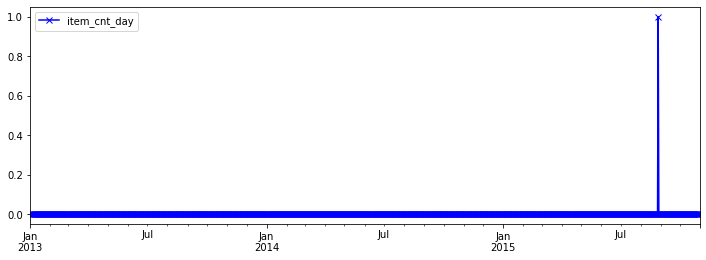

In [37]:
i = 3
data = select_data(i)
data.plot(style='bx-', figsize=(12,4));

In [38]:
forecaster(i)

{'ID': 3,
 'deg1': 0.011111111111111112,
 'deg2': 0.011111111111111112,
 'deg3': 0.011111111111111112}

In [39]:
ridx = pd.date_range(train.index.min(), train.index.max()) # used to reindex
ridx

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2015-10-22', '2015-10-23', '2015-10-24', '2015-10-25',
               '2015-10-26', '2015-10-27', '2015-10-28', '2015-10-29',
               '2015-10-30', '2015-10-31'],
              dtype='datetime64[ns]', length=1034, freq='D')

In [40]:
data.reindex(ridx, fill_value=0)

,item_cnt_day
2013-01-01,0.0
2013-01-02,0.0
2013-01-03,0.0
2013-01-04,0.0
2013-01-05,0.0
...,...
2015-10-27,0.0
2015-10-28,0.0
2015-10-29,0.0
2015-10-30,0.0


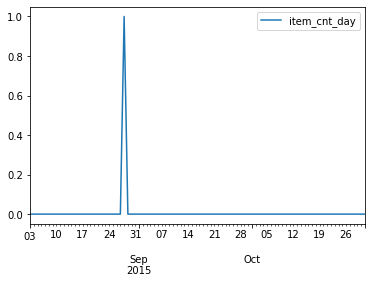

In [41]:
data[-nperiods*3 :].plot()